In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("./plots/paper.mplstyle")  # Use custom stylesheet
from matplotlib.colors import LogNorm
import pc_analysis as pca
import scipy.stats as sps

#Some custom colors
yellow = '#fcd024'
orange = '#f2844b'
red = '#bc3587'
blue = '#330498'

#Load the superdarn data from the cnvmap files. Data from this routine is stored in superdarn.h5, so it is left commented here.
#If you wish to reprocess the data for any reason, uncomment.
#superdarn = pca.data_load_routine()

/tmp/ipykernel_487/387895700.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [11]:
#Load solar wind data from PRIME
sw_data = pd.read_hdf('data/wind_data_full.h5', 'prime_full') #Load solar wind data from PRIME
sw_data = sw_data.drop_duplicates(subset='Epoch') #Just in case!
#Caluclate Em from solar wind data
sw_data['E_KL'] = pca.EKL(sw_data['Vi_xgse'].to_numpy(), sw_data['Vi_ygse'].to_numpy(), sw_data['Vi_zgse'].to_numpy(), sw_data['B_ygsm'].to_numpy(), sw_data['B_zgsm'].to_numpy()) #Kan-Lee electric field
sw_data['E_KL_sig'] = pca.EKL_err(sw_data['Vi_xgse'].to_numpy(), sw_data['Vi_xgse_sig'].to_numpy(), sw_data['Vi_ygse'].to_numpy(), sw_data['Vi_ygse_sig'].to_numpy(), sw_data['Vi_zgse'].to_numpy(), sw_data['Vi_zgse_sig'].to_numpy(), sw_data['B_ygsm'].to_numpy(), sw_data['B_ygsm_sig'].to_numpy(), sw_data['B_zgsm'].to_numpy(), sw_data['B_zgsm_sig'].to_numpy()) #Kan-Lee electric field
sw_data['Em_R'] = pca.EMR(sw_data['Vi_xgse'].to_numpy(), sw_data['B_zgsm'].to_numpy()) #Rectified dawn-dusk motional electric field
sw_data['Em_R_sig'] = pca.EMR_err(sw_data['Vi_xgse'].to_numpy(), sw_data['Vi_xgse_sig'].to_numpy(), sw_data['B_zgsm'].to_numpy(), sw_data['B_zgsm_sig'].to_numpy()) #Error in rectified dawn-dusk motional electric field
# sw_data['Em_R'] = pca.EMR(sw_data['Vi_xgse'].to_numpy(), sw_data['B_zgsm'].to_numpy(), by = sw_data['B_ygsm'].to_numpy()) #Rectified dawn-dusk motional electric field
# sw_data['Em_R_sig'] = pca.EMR_err(sw_data['Vi_xgse'].to_numpy(), sw_data['Vi_xgse_sig'].to_numpy(), sw_data['B_zgsm'].to_numpy(), sw_data['B_zgsm_sig'].to_numpy(), by = sw_data['B_ygsm'].to_numpy(), by_sig = sw_data['B_ygsm_sig'].to_numpy()) #Error in rectified dawn-dusk motional electric field


#Load outer magnetosheath data from PRIME-SH
sh_data = pd.read_hdf('data/sheath_outputs_cpcp.h5', 'primesh_mid')
sh_data = sh_data.drop_duplicates(subset='Epoch') #Just in case!
sh_data['Erx'] = pca.ERX(sh_data['Ni'].to_numpy(), sh_data['Vi_xgse'].to_numpy(), sh_data['Vi_ygse'].to_numpy(), sh_data['Vi_zgse'].to_numpy(), sh_data['B_xgsm'].to_numpy(), sh_data['B_ygsm'].to_numpy(), sh_data['B_zgsm'].to_numpy(), sh_data['Tiperp'].to_numpy()) #Reconnection electric field
sh_data['Em_R'] = pca.EMR(sh_data['Vi_xgse'].to_numpy(), sh_data['B_zgsm'].to_numpy()) #Rectified dawn-dusk motional electric field
sh_data['Em_R_sig'] = pca.EMR_err(sh_data['Vi_xgse'].to_numpy(), sh_data['Vi_xgse_sig'].to_numpy(), sh_data['B_zgsm'].to_numpy(), sh_data['B_zgsm_sig'].to_numpy(),) #Error in rectified dawn-dusk motional electric field
# sh_data['Em_R'] = pca.EMR(sh_data['Vi_xgse'].to_numpy(), sh_data['B_zgsm'].to_numpy(), by = sh_data['B_ygsm'].to_numpy()) #Rectified dawn-dusk motional electric field
# sh_data['Em_R_sig'] = pca.EMR_err(sh_data['Vi_xgse'].to_numpy(), sh_data['Vi_xgse_sig'].to_numpy(), sh_data['B_zgsm'].to_numpy(), sh_data['B_zgsm_sig'].to_numpy(), by = sh_data['B_ygsm'].to_numpy(), by_sig = sh_data['B_ygsm_sig'].to_numpy()) #Error in rectified dawn-dusk motional electric field
sh_data['E_KL'] = pca.EKL(sh_data['Vi_xgse'].to_numpy(), sh_data['Vi_ygse'].to_numpy(), sh_data['Vi_zgse'].to_numpy(), sh_data['B_ygsm'].to_numpy(), sh_data['B_zgsm'].to_numpy()) #Kan-Lee electric field
sh_data['E_KL_sig'] = pca.EKL_err(sh_data['Vi_xgse'].to_numpy(), sh_data['Vi_xgse_sig'].to_numpy(), sh_data['Vi_ygse'].to_numpy(), sh_data['Vi_ygse_sig'].to_numpy(), sh_data['Vi_zgse'].to_numpy(), sh_data['Vi_zgse_sig'].to_numpy(), sh_data['B_ygsm'].to_numpy(), sh_data['B_ygsm_sig'].to_numpy(), sh_data['B_zgsm'].to_numpy(), sh_data['B_zgsm_sig'].to_numpy()) #Kan-Lee electric field

/mnt/c/Users/conno/Documents/prime-pcp/pc_analysis.py:487: RuntimeWarning: invalid value encountered in sqrt
  erx = 0.02 * 0.2 * (B**2) * (((1+beta)/ni)**(1/2)) * (np.sin(np.arctan2(by, bz)/2))**2 #Reconnection electric field (modified Cassak-Shay)


In [12]:
def closest_argmin(A, B):
    '''
    Helper function that returns indices of elements in array B closest to each element in array A.
    '''
    L = B.size
    sidx_B = B.argsort()
    sorted_B = B[sidx_B]
    sorted_idx = np.searchsorted(sorted_B, A)
    sorted_idx[sorted_idx==L] = L-1
    mask = (sorted_idx > 0) & \
    ((np.abs(A - sorted_B[sorted_idx-1]) < np.abs(A - sorted_B[sorted_idx])) )
    return sidx_B[sorted_idx-mask]

#Load superdarn data
superdarn = pd.read_hdf('data/superdarn.h5', key = 'all_north') #Load superdarn data
#Also, add the shifted data into superdarn dataframe
timeshift = pd.Timedelta(seconds=17*60) #Time shift between bow shock/magnetosheath and ionosphere
# sw_inds = closest_argmin(superdarn['time'].to_numpy(), sw_data['Epoch'].to_numpy()) #Find the indices of sw_data['Epoch'] closest to each superdarn['time']
# sh_inds = closest_argmin(superdarn['time'].to_numpy(), sh_data['Epoch'].to_numpy()) #Find the indices of sh_data['Epoch'] closest to each superdarn['time']
for key in sw_data.columns: #Add the solar wind data into superdarn
    if key == 'Epoch':
        continue
    # #Add the closest elements of sw_data to superdarn data
    # superdarn[key+'_sw'] = sw_data.loc[sw_inds, key].to_numpy()
    #Interpolate the solar wind data to the CPCP times
    superdarn[key+'_sw'] = np.interp(superdarn['time'].astype('int'), (sw_data['Epoch']+timeshift).astype('int'), sw_data[key])
for key in sh_data.columns: #Add sheath data into superdarn
    if key == 'Epoch':
        continue
    # #Add the closest elements of sw_data to superdarn data
    # superdarn[key+'_sh'] = sh_data.loc[sh_inds, key].to_numpy()
    #Interpolate the solar wind data to the CPCP times
    superdarn[key+'_sh'] = np.interp(superdarn['time'].astype('int'), (sh_data['Epoch']+timeshift).astype('int'), sh_data[key])
# superdarn = superdarn.drop_duplicates(subset = sw_data.columns[1:]+'_sw') #Drop duplicate entries due to solar wind data overlap
# superdarn = superdarn.drop_duplicates(subset = sh_data.columns[1:]+'_sh') #Drop duplicate entries due to sheath data overlap

#Drop superdarn times with NaN values in any of the data variables
superdarn = superdarn.dropna(subset='time')

In [27]:
#Bin and average the polar cap potential with respect to the motional electric field in the solar wind and magnetosheath
#Also, correct for the regression attenuation according to the correction factor from 
sig2b_sw = np.var(np.log(superdarn['Em_R_sw']), ddof = 1) #Population between-timestep variance
sig2w_sw = np.mean(np.log(superdarn['Em_R_sig_sw'])**2) #Population between-measurement variance
lambda_p_sw = (sig2b_sw)/(sig2b_sw + np.log(superdarn['Em_R_sig_sw'])**2) #Regression attenuation correction factor
lambda_blp_sw = sig2b_sw/(np.log(superdarn['Em_R_sig_sw'])**2)
sig2b_sh = np.var(np.log(superdarn['Em_R_sh']), ddof = 1) #Population between-timestep variance
sig2w_sh = np.mean(np.log(superdarn['Em_R_sig_sh'])**2) #Population between-measurement variance
lambda_p_sh = (sig2b_sh)/(sig2b_sh + np.log(superdarn['Em_R_sig_sh'])**2) #Regression attenuation correction factor
lambda_blp_sh = sig2b_sh/(np.log(superdarn['Em_R_sig_sh'])**2)

mask_sw = ~( np.isnan(superdarn['Em_R_sw']) | np.isnan(superdarn['Em_R_sig_sw']) | np.isnan(lambda_p_sw) | np.isnan(superdarn['pot.drop']) | (superdarn['nvec'] < 50) )
superdarn_masked_sw = superdarn.loc[mask_sw, :]
mask_sh = ~( np.isnan(superdarn['Em_R_sh']) | np.isnan(superdarn['Em_R_sig_sh']) | np.isnan(lambda_p_sh) | np.isnan(superdarn['pot.drop']) | (superdarn['nvec'] < 50) )
superdarn_masked_sh = superdarn.loc[mask_sh, :]

Em_corr_sw = np.exp((1-lambda_p_sw[mask_sw])*np.log(np.mean(superdarn_masked_sw['Em_R_sw'])) + 
                    lambda_p_sw[mask_sw]*np.log(superdarn_masked_sw['Em_R_sw']))
Em_corr_sh = np.exp((1-lambda_p_sh[mask_sh])*np.log(np.mean(superdarn_masked_sh['Em_R_sh'])) + 
                    lambda_p_sh[mask_sh]*np.log(superdarn_masked_sh['Em_R_sh']))

xlim = 12 #Em_R limit
ylim = 120 #phipc limit
xbinsize = 0.5 #X binsize (mV/m) for nonlinear regression
phipc_mean_sw, _, _ = sps.binned_statistic(superdarn_masked_sw['Em_R_sw'], superdarn_masked_sw['pot.drop']/1000, statistic = 'mean', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_std_sw, _, _ = sps.binned_statistic(superdarn_masked_sw['Em_R_sw'], superdarn_masked_sw['pot.drop']/1000, statistic = 'std', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_count_sw, bins_sw, binnum_sw = sps.binned_statistic(superdarn_masked_sw['Em_R_sw'], superdarn_masked_sw['pot.drop']/1000, statistic = 'count', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_corr_mean_sw, _, _ = sps.binned_statistic(Em_corr_sw, superdarn_masked_sw['pot.drop']/1000, statistic = 'mean', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_corr_std_sw, _, _ = sps.binned_statistic(Em_corr_sw, superdarn_masked_sw['pot.drop']/1000, statistic = 'std', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_corr_count_sw, bins_corr_sw, binnum_corr_sw = sps.binned_statistic(Em_corr_sw, superdarn_masked_sw['pot.drop']/1000, statistic = 'count', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_mean_sh, _, _ = sps.binned_statistic(superdarn_masked_sh['Em_R_sh'], superdarn_masked_sh['pot.drop']/1000, statistic = 'mean', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_std_sh, _, _ = sps.binned_statistic(superdarn_masked_sh['Em_R_sh'], superdarn_masked_sh['pot.drop']/1000, statistic = 'std', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_count_sh, bins_sh, binnum_sh = sps.binned_statistic(superdarn_masked_sh['Em_R_sh'], superdarn_masked_sh['pot.drop']/1000, statistic = 'count', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_corr_mean_sh, _, _ = sps.binned_statistic(Em_corr_sh, superdarn_masked_sh['pot.drop']/1000, statistic = 'mean', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_corr_std_sh, _, _ = sps.binned_statistic(Em_corr_sh, superdarn_masked_sh['pot.drop']/1000, statistic = 'std', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_corr_count_sh, bins_corr_sh, binnum_corr_sh = sps.binned_statistic(Em_corr_sh, superdarn_masked_sh['pot.drop']/1000, statistic = 'count', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))


regresult_sw = sps.linregress(superdarn_masked_sw['Em_R_sw'], superdarn_masked_sw['pot.drop']/1000) #Linear regression of CPCP on uncorrected solar wind Em_R
regresult_corr_sw = sps.linregress(np.exp(np.log(superdarn_masked_sw['Em_R_sw'])*lambda_p_sw[mask_sw]), superdarn_masked_sw['pot.drop']/1000) #Linear regression of CPCP on corrected solar wind Em_R
regresult_sh = sps.linregress(superdarn_masked_sh['Em_R_sh'], superdarn_masked_sh['pot.drop']/1000) #Linear regression of CPCP on uncorrected magnetosheath Em_R
regresult_corr_sh = sps.linregress(np.exp(np.log(superdarn_masked_sh['Em_R_sh'])*lambda_p_sh[mask_sh]), superdarn_masked_sh['pot.drop']/1000) #Linear regression of CPCP on corrected magnetosheath Em_R
regresult_linear = sps.linregress(np.exp(np.log(superdarn_masked_sw['Em_R_sw'])*lambda_p_sw[mask_sw])[np.exp(np.log(superdarn_masked_sw['Em_R_sw'])*lambda_p_sw[mask_sw]) < 2], 
                              superdarn_masked_sw['pot.drop'][np.exp(np.log(superdarn_masked_sw['Em_R_sw'])*lambda_p_sw[mask_sw]) < 2]/1000) #Linear regression of CPCP on corrected solar wind Em_R in the linear regime


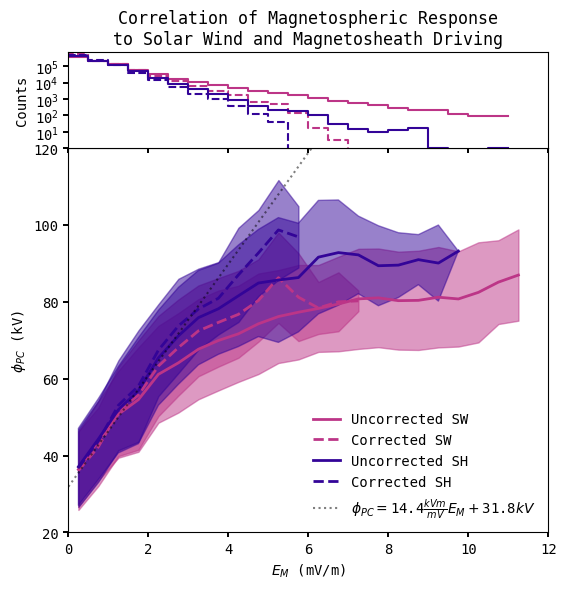

In [39]:
#Plot both lines on top of one another and histograms of SW and SH electric field on top
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and one column and a ratio of 1 to 4 between the size of the marginal Axes and the main Axes.
gs = fig.add_gridspec(2, 1, height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histx.tick_params(axis="x", labelbottom=False)

#Plot the uncorrected and corrected 
ax.plot(bins_sw[:-1]+xbinsize/2, phipc_mean_sw, color=red, linestyle='-', linewidth=2, label = r'Uncorrected SW')#, $\beta$='+str(regresult_sw.slope)[0:4]+r'$\pm$'+str(regresult_sw.stderr)[0:4]) #Plot mean CPCP vs Em_R in each regression line bin
ax.fill_between(bins_sw[:-1]+xbinsize/2, phipc_mean_sw+phipc_std_sw, phipc_mean_sw-phipc_std_sw, color=red, alpha=0.5) #Fill between mean CPCP+1sigma and mean CPCP-1sigma
ax.plot(bins_sw[:-1]+xbinsize/2, phipc_corr_mean_sw, color=red, linestyle='--', linewidth=2, label = r'Corrected SW')#, $\beta$='+str(regresult_corr_sw.slope)[0:4]+r'$\pm$'+str(regresult_corr_sw.stderr)[0:4]) #Plot mean CPCP vs Em_R in each regression line bin
ax.fill_between(bins_sw[:-1]+xbinsize/2, phipc_corr_mean_sw+phipc_corr_std_sw, phipc_corr_mean_sw-phipc_corr_std_sw, color=red, alpha=0.5) #Fill between mean CPCP+1sigma and mean CPCP-1sigma
ax.plot(bins_sh[:-1]+xbinsize/2, phipc_mean_sh, color=blue, linestyle='-', linewidth=2, label = r'Uncorrected SH')#, $\beta$='+str(regresult_sh.slope)[0:4]+r'$\pm$'+str(regresult_sh.stderr)[0:4]) #Plot mean CPCP vs Em_R in each regression line bin
ax.fill_between(bins_sh[:-1]+xbinsize/2, phipc_mean_sh+phipc_std_sh, phipc_mean_sh-phipc_std_sh, color=blue, alpha=0.5) #Fill between mean CPCP+1sigma and mean CPCP-1sigma
ax.plot(bins_sh[:-1]+xbinsize/2, phipc_corr_mean_sh, color=blue, linestyle='--', linewidth=2, label = r'Corrected SH')#, $\beta$='+str(regresult_corr_sh.slope)[0:4]+r'$\pm$'+str(regresult_corr_sh.stderr)[0:4]) #Plot mean CPCP vs Em_R in each regression line bin
ax.fill_between(bins_sh[:-1]+xbinsize/2, phipc_corr_mean_sh+phipc_corr_std_sh, phipc_corr_mean_sh-phipc_corr_std_sh, color=blue, alpha=0.5) #Fill between mean CPCP+1sigma and mean CPCP-1sigma
ax.plot([0,12], [regresult_linear.intercept, regresult_linear.intercept+regresult_linear.slope*12], 
        color = 'k', alpha = 0.5, linestyle = ':', 
        label = r'$\phi_{PC}=$'+str(regresult_linear.slope)[0:4]+r'$\frac{kVm}{mV}E_{M}+$'+str(regresult_linear.intercept)[0:4]+r'$kV$') #Plot Em vs CPCP relationship from Doyle and Burke (1983)
ax.set_xlabel('$E_{M}$ (mV/m)')
ax.set_ylabel(r'$\phi_{PC}$ (kV)')
ax.set_xlim(0,xlim)
ax.set_ylim(20,ylim)
ax.legend(loc='lower right', frameon = False)

#Histogram of Em_R for corrected and uncorrected values
ax_histx.step(bins_sw[:-1], phipc_count_sw, color = red)
ax_histx.step(bins_sw[:-1], phipc_corr_count_sw, color = red, linestyle = '--')
ax_histx.step(bins_sh[:-1], phipc_count_sh, color = blue)
ax_histx.step(bins_sh[:-1], phipc_corr_count_sh, color = blue, linestyle = '--')
ax_histx.set_yscale('log')
ax_histx.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5])
ax_histx.set_ylim([1e0, 7e5])
ax_histx.set_ylabel('Counts')
ax_histx.set_title('Correlation of Magnetospheric Response\nto Solar Wind and Magnetosheath Driving')
# plt.savefig('./plots/pcp_saturation_correction.pdf', bbox_inches = 'tight')

In [ ]:
#Bin and average the polar cap potential with respect to the Kan-Lee electric field in the solar wind and magnetosheath
#Also, correct for the regression attenuation according to the correction factor from 
sig2b_sw = np.var(np.log(superdarn['E_KL_sw']), ddof = 1) #Population between-timestep variance
sig2w_sw = np.mean(np.log(superdarn['E_KL_sig_sw'])**2) #Population between-measurement variance
lambda_p_sw = 1 + (np.log(superdarn['E_KL_sig_sw'])**2)/(sig2b_sw) #Regression attenuation correction factor
sig2b_sh = np.var(np.log(superdarn['E_KL_sh']), ddof = 1) #Population between-timestep variance
sig2w_sh = np.mean(np.log(superdarn['E_KL_sig_sh'])**2) #Population between-measurement variance
lambda_p_sh = 1 + (np.log(superdarn['E_KL_sig_sh'])**2)/(sig2b_sh) #Regression attenuation correction factor

mask_sw = ~( np.isnan(superdarn['E_KL_sw']) | np.isnan(superdarn['E_KL_sig_sw']) | np.isnan(lambda_p_sw) | np.isnan(superdarn['pot.drop']) | (superdarn['nvec'] < 50) )
superdarn_masked_sw = superdarn.loc[mask_sw, :]
mask_sh = ~( np.isnan(superdarn['E_KL_sh']) | np.isnan(superdarn['E_KL_sig_sh']) | np.isnan(lambda_p_sh) | np.isnan(superdarn['pot.drop']) | (superdarn['nvec'] < 50) )
superdarn_masked_sh = superdarn.loc[mask_sh, :]

xlim = 12 #E_KL limit
ylim = 120 #phipc limit
xbinsize = 0.5 #X binsize (mV/m) for nonlinear regression
phipc_mean_sw, _, _ = sps.binned_statistic(superdarn_masked_sw['E_KL_sw'], superdarn_masked_sw['pot.drop']/1000, statistic = 'mean', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_std_sw, _, _ = sps.binned_statistic(superdarn_masked_sw['E_KL_sw'], superdarn_masked_sw['pot.drop']/1000, statistic = 'std', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_count_sw, bins_sw, binnum_sw = sps.binned_statistic(superdarn_masked_sw['E_KL_sw'], superdarn_masked_sw['pot.drop']/1000, statistic = 'count', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_corr_mean_sw, _, _ = sps.binned_statistic(np.exp(np.log(superdarn_masked_sw['E_KL_sw'])/lambda_p_sw[mask_sw]), superdarn_masked_sw['pot.drop']/1000, statistic = 'mean', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_corr_std_sw, _, _ = sps.binned_statistic(np.exp(np.log(superdarn_masked_sw['E_KL_sw']/lambda_p_sw[mask_sw])), superdarn_masked_sw['pot.drop']/1000, statistic = 'std', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_corr_count_sw, bins_corr_sw, binnum_corr_sw = sps.binned_statistic(np.exp(np.log(superdarn_masked_sw['E_KL_sw']/lambda_p_sw[mask_sw])), superdarn_masked_sw['pot.drop']/1000, statistic = 'count', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_mean_sh, _, _ = sps.binned_statistic(superdarn_masked_sh['E_KL_sh'], superdarn_masked_sh['pot.drop']/1000, statistic = 'mean', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_std_sh, _, _ = sps.binned_statistic(superdarn_masked_sh['E_KL_sh'], superdarn_masked_sh['pot.drop']/1000, statistic = 'std', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_count_sh, bins_sh, binnum_sh = sps.binned_statistic(superdarn_masked_sh['E_KL_sh'], superdarn_masked_sh['pot.drop']/1000, statistic = 'count', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_corr_mean_sh, _, _ = sps.binned_statistic(np.exp(np.log(superdarn_masked_sh['E_KL_sh']/lambda_p_sh[mask_sh])), superdarn_masked_sh['pot.drop']/1000, statistic = 'mean', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_corr_std_sh, _, _ = sps.binned_statistic(np.exp(np.log(superdarn_masked_sh['E_KL_sh']/lambda_p_sh[mask_sh])), superdarn_masked_sh['pot.drop']/1000, statistic = 'std', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))
phipc_corr_count_sh, bins_corr_sh, binnum_corr_sh = sps.binned_statistic(np.exp(np.log(superdarn_masked_sh['E_KL_sh']/lambda_p_sh[mask_sh])), superdarn_masked_sh['pot.drop']/1000, statistic = 'count', bins = np.arange(0,xlim,xbinsize), range = (0,xlim))

regresult_sw = sps.linregress(superdarn_masked_sw['E_KL_sw'], superdarn_masked_sw['pot.drop']/1000) #Linear regression of CPCP on uccorrected solar wind E_KL
regresult_corr_sw = sps.linregress(np.exp(np.log(superdarn_masked_sw['E_KL_sw'])/lambda_p_sw[mask_sw]), superdarn_masked_sw['pot.drop']/1000) #Linear regression of CPCP on corrected solar wind E_KL
regresult_sh = sps.linregress(superdarn_masked_sh['E_KL_sh'], superdarn_masked_sh['pot.drop']/1000) #Linear regression of CPCP on uccorrected magnetosheath E_KL
regresult_corr_sh = sps.linregress(np.exp(np.log(superdarn_masked_sh['E_KL_sh'])/lambda_p_sh[mask_sh]), superdarn_masked_sh['pot.drop']/1000) #Linear regression of CPCP on corrected magnetosheath E_KL

Text(0.5, 1.0, 'Correlation of Magnetospheric Response\nto Solar Wind and Magnetosheath Driving')

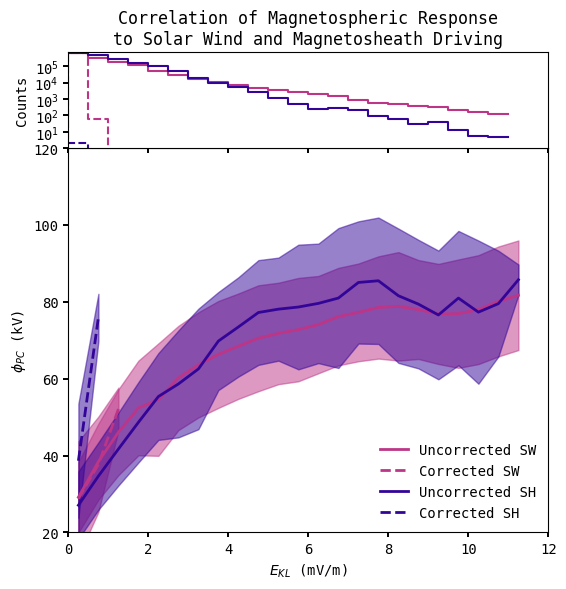

In [14]:
#Plot both lines on top of one another and histograms of SW and SH Kan-Lee electric field on top
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and one column and a ratio of 1 to 4 between the size of the marginal Axes and the main Axes.
gs = fig.add_gridspec(2, 1, height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histx.tick_params(axis="x", labelbottom=False)

#Plot the uncorrected and corrected 
ax.plot(bins_sw[:-1]+xbinsize/2, phipc_mean_sw, color=red, linestyle='-', linewidth=2, label = r'Uncorrected SW')#, $\beta$='+str(regresult_sw.slope)[0:4]+r'$\pm$'+str(regresult_sw.stderr)[0:4]) #Plot mean CPCP vs E_KL in each regression line bin
ax.fill_between(bins_sw[:-1]+xbinsize/2, phipc_mean_sw+phipc_std_sw, phipc_mean_sw-phipc_std_sw, color=red, alpha=0.5) #Fill between mean CPCP+1sigma and mean CPCP-1sigma
ax.plot(bins_sw[:-1]+xbinsize/2, phipc_corr_mean_sw, color=red, linestyle='--', linewidth=2, label = r'Corrected SW')#, $\beta$='+str(regresult_corr_sw.slope)[0:4]+r'$\pm$'+str(regresult_corr_sw.stderr)[0:4]) #Plot mean CPCP vs E_KL in each regression line bin
ax.fill_between(bins_sw[:-1]+xbinsize/2, phipc_corr_mean_sw+phipc_corr_std_sw, phipc_corr_mean_sw-phipc_corr_std_sw, color=red, alpha=0.5) #Fill between mean CPCP+1sigma and mean CPCP-1sigma
ax.plot(bins_sh[:-1]+xbinsize/2, phipc_mean_sh, color=blue, linestyle='-', linewidth=2, label = r'Uncorrected SH')#, $\beta$='+str(regresult_sh.slope)[0:4]+r'$\pm$'+str(regresult_sh.stderr)[0:4]) #Plot mean CPCP vs E_KL in each regression line bin
ax.fill_between(bins_sh[:-1]+xbinsize/2, phipc_mean_sh+phipc_std_sh, phipc_mean_sh-phipc_std_sh, color=blue, alpha=0.5) #Fill between mean CPCP+1sigma and mean CPCP-1sigma
ax.plot(bins_sh[:-1]+xbinsize/2, phipc_corr_mean_sh, color=blue, linestyle='--', linewidth=2, label = r'Corrected SH')#, $\beta$='+str(regresult_corr_sh.slope)[0:4]+r'$\pm$'+str(regresult_corr_sh.stderr)[0:4]) #Plot mean CPCP vs E_KL in each regression line bin
ax.fill_between(bins_sh[:-1]+xbinsize/2, phipc_corr_mean_sh+phipc_corr_std_sh, phipc_corr_mean_sh-phipc_corr_std_sh, color=blue, alpha=0.5) #Fill between mean CPCP+1sigma and mean CPCP-1sigma
ax.set_xlabel('$E_{KL}$ (mV/m)')
ax.set_ylabel(r'$\phi_{PC}$ (kV)')
ax.set_xlim(0,xlim)
ax.set_ylim(20,ylim)
ax.legend(loc='lower right', frameon = False)

#Histogram of E_KL for corrected and uncorrected values
ax_histx.step(bins_sw[:-1], phipc_count_sw, color = red)
ax_histx.step(bins_sw[:-1], phipc_corr_count_sw, color = red, linestyle = '--')
ax_histx.step(bins_sh[:-1], phipc_count_sh, color = blue)
ax_histx.step(bins_sh[:-1], phipc_corr_count_sh, color = blue, linestyle = '--')
ax_histx.set_yscale('log')
ax_histx.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5])
ax_histx.set_ylim([1e0, 7e5])
ax_histx.set_ylabel('Counts')
ax_histx.set_title('Correlation of Magnetospheric Response\nto Solar Wind and Magnetosheath Driving')
# plt.savefig('./plots/pcp_saturation_correction.pdf', bbox_inches = 'tight')

/tmp/ipykernel_403/1602760031.py:4: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contour(np.linspace(-15,3,18)[:-1], np.linspace(0,8,20)[:-1], hist, norm=LogNorm(), cmap = 'inferno') #Contour plot all the data


Text(0, 0.5, 'Solar Wind $\\sigma E_{M}$ (mV/m)')

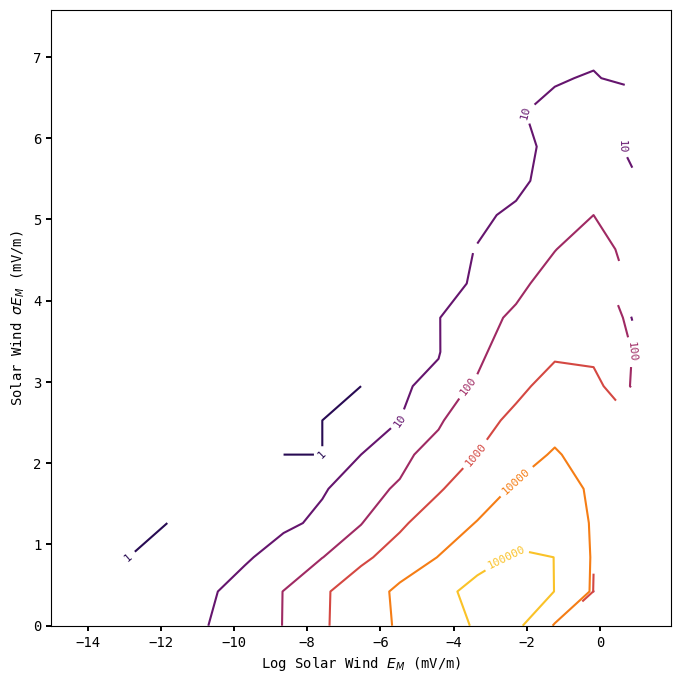

In [44]:
#Logspace distribution plot
hist, _, _ = np.histogram2d(superdarn_masked_sw['Em_R_sig_sw'], np.log(superdarn_masked_sw['Em_R_sw']), bins=[np.linspace(0,8,20), np.linspace(-15,5,18)]) #Make the histogram to base the countours on
fig, ax = plt.subplots(nrows = 1, ncols = 1 , figsize = (8,8))
cs = ax.contour(np.linspace(-15,3,18)[:-1], np.linspace(0,8,20)[:-1], hist, norm=LogNorm(), cmap = 'inferno') #Contour plot all the data
ax.clabel(cs, inline=True, fontsize=8) #Label the contours
ax.set_xlabel(r'Log Solar Wind $E_{M}$ (mV/m)')
ax.set_ylabel(r'Solar Wind $\sigma E_{M}$ (mV/m)')
# ax.set_ylabel(r'$\phi_{PC}$ (kV)')

In [ ]:
#DEPRECATED CODE CELL


# #Obtain the error in Em in sh_data_mid from the errors in the parameters in a Bayesian way
sh_mid_temp = pd.read_hdf('./data/sh_data_tempstorage.h5', key='sh_data_mid')
# sh_mid_temp['Em_resample'] = np.zeros(len(sh_mid_temp)) #Stage the errors in the dataframe
# n = 1000 #Samples to draw for each parameter
# for i in np.arange(len(sh_mid_temp)):
#     bz = np.random.normal(sh_mid_temp['B_zgsm'][i], sh_mid_temp['B_zgsm_sig'][i], n)
#     vx = np.random.normal(sh_mid_temp['Vi_xgse'][i], sh_mid_temp['Vi_xgse_sig'][i], n)
#     sh_mid_temp.loc[i,'Em_resample'] = np.mean(0.001*vx*bz) #Calculate Em for each sample
#     sh_mid_temp.loc[i,'Em_resample_std'] = np.std(0.001*vx*bz) #Calculate the standard deviation of Em for each sample
#     print(str(i+1)+'/'+str(len(sh_mid_temp)), end='\r')
# sh_mid_temp.to_hdf('./data/sh_data_tempstorage.h5', key='sh_data_mid')

superdarn['Em_resample'] = np.interp(superdarn['time'].astype('int'), (sh_mid_temp['Epoch']+timeshift).astype('int'), sh_mid_temp['Em_resample']) #Interpolate the errors in Em from the errors in the parameters
superdarn['Em_resample_std'] = np.interp(superdarn['time'].astype('int'), (sh_mid_temp['Epoch']+timeshift).astype('int'), sh_mid_temp['Em_resample_std']) #Interpolate the errors in Em from the errors in the parameters
mask = np.isnan(superdarn['Em_resample']) | np.isnan(superdarn['Em_resample_std']) | np.isnan(superdarn['pot.drop']) | (superdarn['nvec'] < 50) | (superdarn['Em_resample'] < 0)result = sps.linregress(superdarn['Em_resample'][~mask], superdarn['pot.drop'][~mask]/1000)
comp_fac = np.var(superdarn['Em_R_sh'])/(np.var(superdarn['Em_R_sh']) - superdarn['Em_resample_std']**2)


### Plot distribution of calculated Em to show skewness
i = 3299600
n = 1000

bz = np.random.normal(sh_data_mid['B_zgsm'][i], sh_data_mid['B_zgsm_sig'][i], n)
vx = np.random.normal(sh_data_mid['Vi_xgse'][i], sh_data_mid['Vi_xgse_sig'][i], n)

Em = 0.001*vx*bz

n, bins, patches = plt.hist(Em, bins=20, density=True, alpha=0.5, color='b')
plt.vlines(sh_data_mid['Em'][i], 0, np.max(n), color='r')
plt.vlines(np.mean(Em), 0, np.max(n), color='r', linestyle='--')

#Error distribution plot
mask = np.isnan(superdarn['Em_R_sh']) | np.isnan(superdarn['Em_R_sig_sh']) #Mask out bad/missing data
hist_sig, _, _ = np.histogram2d(superdarn['Em_R_sig_sh'][~mask], superdarn['Em_R_sh'][~mask], bins=[np.linspace(0,5,5*5), np.linspace(0,10,10*5)]) #Make the histogram to base the countours on
fig, ax = plt.subplots(nrows = 1, ncols = 1 , figsize = (8,8))
cs_sig = ax.contour(np.linspace(0,10,10*5)[:-1], np.linspace(0,5,5*5)[:-1], hist_sig, norm=LogNorm(), cmap = 'inferno') #Contour plot all the data
ax.clabel(cs_sig, inline=True, fontsize=8) #Label the contours
ax.set_xlabel(r'Sheath $E_{M}$ (mV/m)')
ax.set_ylabel(r'Sheath $\sigma E_{M}$ (mV/m)')